# Evaluating Experiment Designs Using Fisher Information
In this notebook we step through an example of using the Fisher information matrix of an experiment design to evaluate its theoretical performance. This sort of analysis was done in these two papers : [1](https://arxiv.org/abs/2307.15767) [2](https://arxiv.org/abs/2308.08781).

In [24]:
import pygsti
from pygsti.modelpacks import smq1Q_XYI
from pygsti.tools.edesigntools import calculate_fisher_information_matrices_by_L
from pygsti.protocols import StandardGSTDesign
import numpy as np
import matplotlib.pyplot as plt

Start by loading in a target model from a model pack and creating an experiment design.

In [4]:
target_model = smq1Q_XYI.target_model('full TP')
edesign = smq1Q_XYI.create_gst_experiment_design(128)
maxLs = [1,2,4,8,16,32,64,128]

The fisher information is a tool for evaluating the theoretical performance of an experiment design. It corresponds to the variance of the score, which under suitable regularity conditions reducts to the hessian of the log-likelihood function with respect to the model parameters. Definitition aside, the power of the Fisher information comes from the Cramer-Rao bound, which says that the covariance matrix of estimates generated with respect to an experiment design is lower bounded by the inverse of that design's Fisher information matrix.

Below we will calculate the Fisher information matrices for each nested iteration of the GST experiment design we have constructed (we'll assume 100 shots per-circuit).

In [5]:
fisher_infos_by_L = calculate_fisher_information_matrices_by_L(target_model, edesign.circuit_lists, maxLs, num_shots=100)

Next we will calculate the eigenvalues of each of these Fisher information matrices:

In [11]:
fim_spectra_by_L = [np.linalg.eigvalsh(fim) for fim in fisher_infos_by_L.values()]

The reciprocals of these eigenvalues correspond to the lengths of the axes of the uncertainty ellipsoid defined by the covariance for our estimate. So, for a well-constructed GST experiment design we expect to see a linear increase in the Fisher information eigenvalues associated with amplifiable parameters (non-SPAM, non-gauge). 

We can evaluate this by simply plotting these directly. (Helper function defined below)

In [19]:
def plot_spectra_by_L(fisher_spectra_by_L, Ls, num_gauge, figure_size=None):
    #In this version only plot the positive part of the spectra
    
    #convert this spectra to a numpy array
    fisher_array= np.asarray(fisher_spectra_by_L)
    #this should have rows corresponding to the length and columns corresponding to the eigenvalues at that length in increasing order.
    #to get eigenvalue bands we should be able to just take the columns and plot those.
        
    #drop the stated number of gauge parameters
    if figure_size is not None:
        plt.figure(figsize=figure_size)
    
    for i in range(num_gauge, fisher_array.shape[1]):
        plt.plot(Ls, fisher_array[:,i])

    #also plot a line for the x axis.
    plt.plot(Ls, [0]*len(Ls), 'k')
    plt.xscale('log')
    plt.yscale('log')
    plt.xticks(Ls, Ls)
    
    #Addtional Formatting
    plt.xlabel(r'$L$, (maximum base circuit depth)', fontsize=16)
    plt.xlim([0.9, Ls[-1]])
    plt.ylabel('Eigenvalue', fontsize=16)

    plt.show()

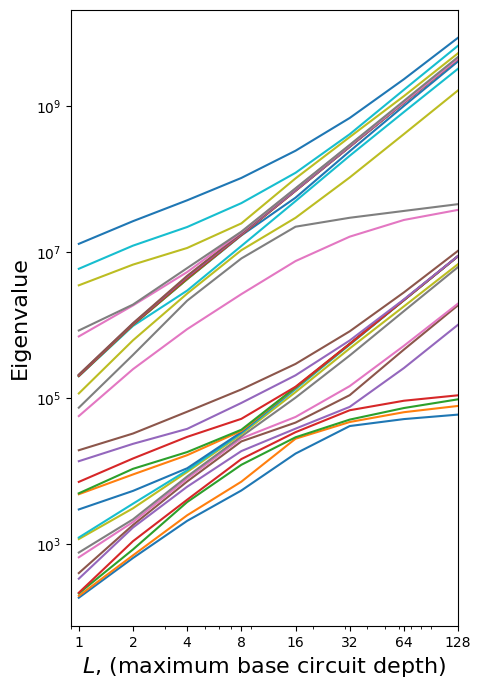

In [21]:
plot_spectra_by_L(fim_spectra_by_L, maxLs, num_gauge=target_model.num_gauge_params, figure_size=(5,8))

A linear scaling of the Fisher information eigenvalues corresponding to amplifiable parameters is exactly what we get here. You may notice that there are 6 traces that are very clearly plateauing. These correspond to the 6 non-gauge SPAM parameters in this particular gate set model, so this too is as expected since SPAM parameters are not amplifiable (essentially because SPAM operations only ever happen once in a circuit).

What about with an experiment design that we know is incomplete? One simple example would be an experiment design constructed with respect to a germ set we call the 'bare' germs, which are simply germs correspoding to the gates of the gate set themselves, and is known not to be amplificationally complete for this gate set.

In [32]:
bare_germs= smq1Q_XYI.germs()[0:3]
print(bare_germs)
prep_fids = smq1Q_XYI.prep_fiducials()
meas_fids = smq1Q_XYI.meas_fiducials()
incomplete_edesign = StandardGSTDesign(target_model, prep_fids, meas_fids, bare_germs, maxLs)

[Circuit([]@(0)), Circuit(Gxpi2:0@(0)), Circuit(Gypi2:0@(0))]


In [33]:
fisher_infos_by_L_incomplete = calculate_fisher_information_matrices_by_L(target_model, incomplete_edesign.circuit_lists, maxLs, num_shots=100)

In [34]:
fim_spectra_by_L_incomplete = [np.linalg.eigvalsh(fim) for fim in fisher_infos_by_L_incomplete.values()]

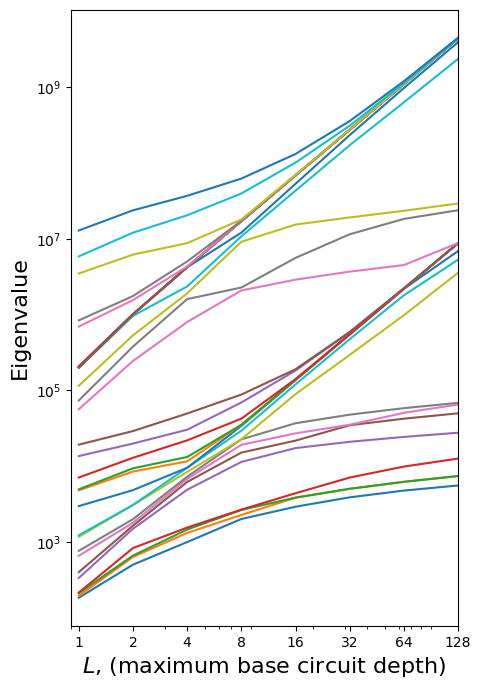

In [35]:
plot_spectra_by_L(fim_spectra_by_L_incomplete, maxLs, num_gauge=target_model.num_gauge_params, figure_size=(5,8))

Here we can see that we now have at least 10 fisher information eigenvalues plateuing, more than can be accounted for due to SPAM alone. This indicates that we are no longer achieving heisenberg-limited precision scaling for our estimates of at least 4 amplifiable parameters of the gate set.